In [48]:
# ===== CLEAN SETUP FOR COLAB =====
# Uninstall noisy packages that force incompatible deps
%pip -q uninstall -y tensorflow-text tf-keras tensorflow-decision-forests ydf jax pytensor umap-learn opentelemetry-proto opencv-contrib-python opencv-python-headless || true

# Minimal, compatible stack for our ECG model
%pip -q install \
  tensorflow==2.16.1 \
  protobuf==4.25.3 \
  numpy==1.26.4 \
  scipy==1.13.1 \
  scikit-learn==1.5.2 \
  pandas==2.2.2 \
  matplotlib==3.9.0 \
  wfdb==4.1.2 \
  requests==2.32.3 \
  tqdm==4.66.4

import platform, tensorflow as tf, numpy as np, pandas as pd, scipy, sklearn, wfdb
print("✅ Setup complete")
print("Python:", platform.python_version())
print("TensorFlow:", tf.__version__)
print("NumPy:", np.__version__)
print("pandas:", pd.__version__)
print("SciPy:", scipy.__version__)
print("scikit-learn:", sklearn.__version__)
print("WFDB:", wfdb.__version__)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 6.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.2 requires jax>=0.1.72, which is not installed.
dopamine-rl 4.1.2 requires tf-keras>=2.18.0, which is not installed.
opentelemetry-exporter-otlp-proto-http 1.37.0 requires opentelemetry-proto==1.37.0, which is not installed.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.3 which is incompatible.
tsfresh 0.21.1 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
dataproc-spark-connect 0.8.3 requires tqdm>=4.67, but you have tqdm 4.66.4 which is incompatible.
google-adk 1.16.0 requires requests<3.

In [49]:
# Small compat patch to align with Colab’s pinned deps
%pip -q install -U requests==2.32.4 tqdm==4.67.1 protobuf==5.26.1
import requests, tqdm, google
print("requests:", requests.__version__)
import importlib, pkgutil
print("✅ Patched. Continue with your pipeline cell.")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.8/64.8 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.8/302.8 kB 11.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.2 requires jax>=0.1.72, which is not installed.
dopamine-rl 4.1.2 requires tf-keras>=2.18.0, which is not installed.
tensorflow-hub 0.16.1 requires tf-keras>=2.14.1, which is not installed.
orbax-checkpoint 0.11.24 requires jax>=0.5.0, which is not installed.
opentelemetry-exporter-otlp-proto-http 1.37.0 requires opentelemetry-proto==1.37.0, which is not installed.
tensorflow 2.16.1 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have pr

In [55]:
# ===== SILENT MI / ACUTE MI PREDICTOR (PTB-XL) — FULL PIPELINE =====

import os, ast, json, re, math, random, warnings, time
warnings.filterwarnings("ignore")

from pathlib import Path
import numpy as np
import pandas as pd

from tqdm import tqdm
import requests, wfdb

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# -------------------------
# 0) Config / constants
# -------------------------
BASE = Path("/content")
PTBXL_DB = BASE / "ptbxl_database.csv"
SCP_CSV  = BASE / "scp_statements.csv"
RECORDS  = BASE / "RECORDS"        # text file with stems like: records500/00000/00001
PHYSIONET_BASE = "https://physionet.org/files/ptb-xl/1.0.3"  # official source

IMG_SIZE = (224, 224)   # (unused for this CNN, kept for reference)
BATCH    = 32
EPOCHS   = 20
SEED     = 42
TARGET_LEN = 1000       # 10 seconds at 100 Hz for PTB-XL low-res

random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

# Sanity: check your uploads
assert PTBXL_DB.exists(), "Missing ptbxl_database.csv in /content"
assert SCP_CSV.exists(),  "Missing scp_statements.csv in /content"
assert RECORDS.exists(),  "Missing RECORDS file in /content"

# --------------------------------------
# 1) Load CSVs + restrict to your RECORDS
# --------------------------------------
df  = pd.read_csv(PTBXL_DB)
scp = pd.read_csv(SCP_CSV, index_col=0)

def parse_present_codes(s):
    try:
        d = ast.literal_eval(s) if isinstance(s, str) else (s if isinstance(s, dict) else {})
    except Exception:
        d = {}
    # keep keys with nonzero weight
    return [k for k, v in d.items() if float(v) > 0.0]

df["labels_all"] = df["scp_codes"].apply(parse_present_codes)
# rec_key should be the WFDB stem (no extension). Use filename_lr without .mat if present, else filename_hr.
if "filename_lr" in df.columns:
    df["rec_key"] = df["filename_lr"].str.replace(".mat", "", regex=False)
else:
    df["rec_key"] = df["filename_hr"].str.replace(".mat", "", regex=False)

# Load RECORDS list (stems). Accept both with and without extension lines.
with open(RECORDS, "r") as f:
    rec_list = []
    for ln in f:
        s = ln.strip()
        if not s: continue
        s = s.replace(".mat","").replace(".dat","").replace(".hea","")
        rec_list.append(s)
rec_set = set(rec_list)

# --- Normalize RECORDS lines to valid PTB-XL stems ---
norm_list = []
for s in rec_list:
    s = s.replace(".mat","").replace(".dat","").replace(".hea","")
    # If lines start with "records/" instead of "records500/" or "records100/",
    # convert automatically to "records500/" (for low-resolution 100 Hz signals)
    if s.startswith("records/"):
        s = s.replace("records/", "records500/", 1)
    norm_list.append(s)

rec_set = set(norm_list)

# Apply to dataframe
df = df[df["rec_key"].isin(rec_set)].reset_index(drop=True)
print(f"Matched {len(df)} rows to normalized RECORDS.")


df = df[df["rec_key"].isin(rec_set)].reset_index(drop=True)
print(f"Matched {len(df)} rows to RECORDS.")

# --------------------------------------
# 2) Fetch WFDB files (.dat/.hea) if missing
# --------------------------------------
def ensure_local_record(rec_key: str, root="/content", retries=3, timeout=60):
    """
    Ensures /content/<rec_key>.dat and .hea exist; downloads from PhysioNet if missing.
    """
    dat = os.path.join(root, rec_key + ".dat")
    hea = os.path.join(root, rec_key + ".hea")
    if os.path.isfile(dat) and os.path.isfile(hea):
        return True

    # Make dirs
    os.makedirs(os.path.dirname(dat), exist_ok=True)

    for ext in [".dat", ".hea"]:
        out = os.path.join(root, rec_key + ext)
        if os.path.isfile(out):
            continue
        url = f"{PHYSIONET_BASE}/{rec_key}{ext}"
        ok = False
        for attempt in range(1, retries+1):
            try:
                r = requests.get(url, timeout=timeout)
                r.raise_for_status()
                with open(out, "wb") as fp:
                    fp.write(r.content)
                ok = True
                break
            except Exception as e:
                if attempt == retries:
                    print(f"❌ Failed to fetch {url}: {e}")
                time.sleep(1.0)
        if not ok:
            return False
    return True

print("Checking/downloading WFDB records (this may take a while on first run)...")
fail_ct = 0
for rk in tqdm(df["rec_key"].tolist()):
    if not ensure_local_record(rk):
        fail_ct += 1
print("Download failures:", fail_ct)

# --------------------------------------
# 3) Make 3-class labels: Normal / Silent_MI / Acute_MI
# --------------------------------------
def _norm(s): return str(s).lower() if isinstance(s, str) else ""

def _get_col(dfcols, options):
    low = {c.lower(): c for c in dfcols}
    for opt in options:
        if opt in low: return low[opt]
    return None

col_diag_class = _get_col(scp.columns, ["diagnostic_class","class","superclass"])
col_description = _get_col(scp.columns, ["description","diagnostic","detailed_description","full_description"])
has_desc = col_description is not None

ACUTE_TOKENS = ["acute", "stemi", "nstemi", "ami", "acute myocardial"]
SILENT_HINTS = ["old", "previous", "healed", "scar"]

def classify_mi_codes(code_list):
    if not code_list: return None
    acute = False
    mi_present = False
    for code in code_list:
        if code not in scp.index: continue
        row = scp.loc[code]
        diag_class = _norm(row.get(col_diag_class, ""))
        if diag_class == "mi":
            mi_present = True
            desc = _norm(row.get(col_description, "")) if has_desc else ""
            if any(tok in desc for tok in ACUTE_TOKENS) or any(tok in _norm(code) for tok in ACUTE_TOKENS):
                acute = True
            if code.upper() in ["AMI","STEMI","NSTEMI"]:
                acute = True
    if mi_present:
        return "Acute_MI" if acute else "Silent_MI"
    return None

def parse_scp_dict(s):
    try:
        return ast.literal_eval(s) if isinstance(s, str) else (s if isinstance(s, dict) else {})
    except Exception:
        return {}

df["scp_codes_dict"] = df["scp_codes"].apply(parse_scp_dict)

labels = []
for _, r in df.iterrows():
    codes = list(r["scp_codes_dict"].keys())
    mi = classify_mi_codes(codes)
    if mi is not None:
        labels.append(mi)
    else:
        dclass = r.get("diagnostic_class", "")
        if isinstance(dclass, str) and dclass.upper() == "NORM":
            labels.append("Normal")
        else:
            labels.append("Other")

df["target3"] = labels
df3 = df[df["target3"].isin(["Normal","Silent_MI","Acute_MI"])].reset_index(drop=True)
print("Label counts (filtered to our 3 classes):")
print(df3["target3"].value_counts())

# --------------------------------------
# 4) Load WFDB signals for rec_key stems
# --------------------------------------
def center_pad_or_truncate(x, tgt=TARGET_LEN):
    T = x.shape[1]
    if T == tgt: return x
    if T > tgt:
        start = (T - tgt)//2
        return x[:, start:start+tgt]
    pad = tgt - T
    left = pad//2
    right = pad - left
    return np.pad(x, ((0,0),(left,right)), mode="constant", constant_values=0.0)

def load_wfdb_by_rec_key(rec_key: str, root="/content"):
    stem = os.path.join(root, rec_key)
    sig, meta = wfdb.rdsamp(stem)  # (T, n_leads) floats
    sig = sig.T.astype(np.float32) # (12, T)
    return sig

def sex_to_num(s):
    s = str(s).strip().lower()
    if s.startswith("m"): return 1
    if s.startswith("f"): return 0
    try:
        v = float(s); return 1 if v > 0.5 else 0
    except: return 0

print("\nLoading ECGs...")
ecgs, demos, ys = [], [], []
missing = 0
CLASSES = ["Normal","Silent_MI","Acute_MI"]
class_to_id = {c:i for i,c in enumerate(CLASSES)}

for _, r in tqdm(df3.iterrows(), total=len(df3)):
    rk = r["rec_key"]
    dat = BASE / f"{rk}.dat"
    hea = BASE / f"{rk}.hea"
    if not (dat.exists() and hea.exists()):
        missing += 1
        continue
    try:
        sig = load_wfdb_by_rec_key(rk)  # (12, T)
        if sig.shape[0] != 12: continue
        sig = center_pad_or_truncate(sig, TARGET_LEN)
        # robust per-lead z-norm
        mu = np.median(sig, axis=1, keepdims=True)
        sd = np.std(sig, axis=1, keepdims=True) + 1e-6
        sig = (sig - mu) / sd
        ecgs.append(sig[..., None])  # (12, T, 1)

        # demographics
        age = float(r.get("age", np.nan))
        if not (0 < age < 120): age = np.nan
        sx = sex_to_num(r.get("sex",""))
        demos.append([0.0 if np.isnan(age) else age, sx])

        ys.append(class_to_id[r["target3"]])
    except Exception:
        continue

X_ecg = np.asarray(ecgs, dtype=np.float32)
X_demo = np.asarray(demos, dtype=np.float32)
y = np.asarray(ys, dtype=np.int64)

print(f"Loaded {len(y)} samples. (Skipped {missing} missing/unreadable.)")
if len(y) == 0:
    raise RuntimeError("No ECGs loaded. Verify the download step completed and paths like /content/records500/00000/00001.(dat|hea) exist.")

# --------------------------------------
# 5) Split
# --------------------------------------
X_e_train, X_e_tmp, X_d_train, X_d_tmp, y_train, y_tmp = train_test_split(
    X_ecg, X_demo, y, test_size=0.30, random_state=SEED, stratify=y
)
X_e_val, X_e_test, X_d_val, X_d_test, y_val, y_test = train_test_split(
    X_e_tmp, X_d_tmp, y_tmp, test_size=0.50, random_state=SEED, stratify=y_tmp
)

# --------------------------------------
# 6) Model: 2D CNN over (leads x time) + demographic branch
# --------------------------------------
def build_model(time_len=TARGET_LEN, n_leads=12, n_classes=3):
    ecg_in = keras.Input(shape=(n_leads, time_len, 1), name="ecg")
    x = layers.Conv2D(16, (3,7), strides=(1,2), padding="same")(ecg_in)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    x = layers.MaxPool2D(pool_size=(1,2))(x)

    x = layers.Conv2D(32, (3,7), strides=(1,2), padding="same")(x)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    x = layers.MaxPool2D(pool_size=(1,2))(x)

    x = layers.Conv2D(64, (3,7), strides=(1,2), padding="same")(x)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    x = layers.GlobalAveragePooling2D()(x)

    demo_in = keras.Input(shape=(2,), name="demo")  # [age, sex]
    norm = layers.Normalization()
    d = norm(demo_in)
    d = layers.Dense(16, activation="relu")(d)

    h = layers.Concatenate()([x, d])
    h = layers.Dense(64, activation="relu")(h)
    h = layers.Dropout(0.3)(h)
    out = layers.Dense(n_classes, activation="softmax")(h)

    model = keras.Model(inputs=[ecg_in, demo_in], outputs=out)
    model.compile(optimizer=keras.optimizers.Adam(1e-3),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model, norm

model, demo_norm = build_model()
demo_norm.adapt(X_d_train)

# --------------------------------------
# Class weights for imbalance (robust)
# --------------------------------------
from collections import Counter
train_counts = Counter(y_train)
print("Train label counts:", train_counts, " (0=Normal, 1=Silent_MI, 2=Acute_MI)")

present = np.unique(y_train)

if len(present) >= 2:
    # Compute weights only for classes that actually appear in y_train
    cw = compute_class_weight(
        class_weight="balanced",
        classes=present,
        y=y_train
    )
    class_weights = {int(c): float(w) for c, w in zip(present, cw)}
    # (Optional) give missing classes the max weight, so if they appear in val/test they aren't ignored
    maxw = max(class_weights.values())
    for c in [0, 1, 2]:
        class_weights.setdefault(c, maxw)
else:
    # Degenerate case: only one label in training
    print("⚠️ Only one class present in y_train; disabling class weights.")
    class_weights = None

print("Class weights used:", class_weights)


# --------------------------------------
# 7) Train
# --------------------------------------
callbacks = [
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True, verbose=1)
]

history = model.fit(
    {"ecg": X_e_train, "demo": X_d_train},
    y_train,
    validation_data=({"ecg": X_e_val, "demo": X_d_val}, y_val),
    epochs=EPOCHS,
    batch_size=BATCH,
    class_weight=class_weights,
    verbose=1
)




Matched 21798 rows to normalized RECORDS.
Matched 21798 rows to RECORDS.
Checking/downloading WFDB records (this may take a while on first run)...


100%|██████████| 21798/21798 [00:00<00:00, 118755.29it/s]


Download failures: 0
Label counts (filtered to our 3 classes):
target3
Silent_MI    5116
Acute_MI      353
Name: count, dtype: int64

Loading ECGs...


100%|██████████| 5469/5469 [00:18<00:00, 288.70it/s]


Loaded 5469 samples. (Skipped 0 missing/unreadable.)
Train label counts: Counter({np.int64(1): 3581, np.int64(2): 247})  (0=Normal, 1=Silent_MI, 2=Acute_MI)
Class weights used: {1: 0.5344875733035465, 2: 7.748987854251012, 0: 7.748987854251012}
Epoch 1/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 47s 369ms/step - accuracy: 0.4777 - loss: 0.7971 - val_accuracy: 0.7659 - val_loss: 0.6199
Epoch 2/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 81s 358ms/step - accuracy: 0.6703 - loss: 0.6786 - val_accuracy: 0.8524 - val_loss: 0.4942
Epoch 3/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 43s 360ms/step - accuracy: 0.7149 - loss: 0.6286 - val_accuracy: 0.3841 - val_loss: 0.8936
Epoch 4/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 43s 358ms/step - accuracy: 0.7240 - loss: 0.6117 - val_accuracy: 0.1488 - val_loss: 1.3613
Epoch 5/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 42s 352ms/step - accuracy: 0.7533 - loss: 0.5899 - val_accuracy: 0.2427 - val_loss: 1.3446
Epoch 6/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 83s 358ms/step - accuracy: 0.7537 - loss: 0.5745 - val_accur

In [56]:

# --------------------------------------
# 8) Evaluate + Save  (robust to missing classes in test)
# --------------------------------------
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Predict
probs = model.predict({"ecg": X_e_test, "demo": X_d_test}, batch_size=128, verbose=0)
preds = probs.argmax(axis=1)

# Figure out which classes are actually present in y_test
labels_present = np.unique(y_test)
name_map = {0: "Normal", 1: "Silent_MI", 2: "Acute_MI"}
names_present = [name_map[i] for i in labels_present]

print("\nTest Classification Report (only classes present in y_test):")
print(classification_report(
    y_test, preds,
    labels=labels_present,
    target_names=names_present,
    digits=4,
    zero_division=0
))

print("Confusion Matrix (only present classes, in this order):", names_present)
print(confusion_matrix(y_test, preds, labels=labels_present))

# (Optional) Also show calibrated overall accuracy and per-class support
acc = (preds == y_test).mean() if len(y_test) else float('nan')
supports = {name_map[i]: int((y_test==i).sum()) for i in labels_present}
print(f"\nOverall accuracy: {acc:.4f}")
print("Supports:", supports)

# Save model
MODEL_PATH = str(BASE / "silent_mi_cnn_wfdb.h5")
model.save(MODEL_PATH)
print(f"\nModel saved to: {MODEL_PATH}")

# --------------------------------------
# 9) One-off prediction helper
# --------------------------------------
def predict_single_rec(rec_key: str, age: float, sex_str: str, root="/content"):
    """
    rec_key example: 'records500/00000/00001' (stem w/o extension).
    """
    dat = Path(root) / f"{rec_key}.dat"
    hea = Path(root) / f"{rec_key}.hea"
    assert dat.exists() and hea.exists(), f"Missing WFDB files for {rec_key} under {root}"

    sig, _ = wfdb.rdsamp(os.path.join(root, rec_key))
    sig = sig.T.astype(np.float32)
    sig = center_pad_or_truncate(sig, TARGET_LEN)
    sig = (sig - np.median(sig, axis=1, keepdims=True)) / (np.std(sig, axis=1, keepdims=True) + 1e-6)

    x_ecg = sig[np.newaxis, ..., None]                     # (1, 12, T, 1)
    x_demo = np.array([[age, 1 if str(sex_str).lower().startswith("m") else 0]], np.float32)

    p = model.predict({"ecg": x_ecg, "demo": x_demo}, verbose=0)[0]
    label = CLASSES[int(np.argmax(p))]
    return label, {CLASSES[i]: float(p[i]) for i in range(3)}

print("\nUsage example (after training):")
print('pred, probs = predict_single_rec("records500/00000/00001", age=56, sex_str="male")')


Test Classification Report (only classes present in y_test):
              precision    recall  f1-score   support

   Silent_MI     0.9827    0.4440    0.6117       768
    Acute_MI     0.0992    0.8868    0.1784        53

    accuracy                         0.4726       821
   macro avg     0.5409    0.6654    0.3950       821
weighted avg     0.9257    0.4726    0.5837       821

Confusion Matrix (only present classes, in this order): ['Silent_MI', 'Acute_MI']
[[341 427]
 [  6  47]]

Overall accuracy: 0.4726
Supports: {'Silent_MI': 768, 'Acute_MI': 53}

Model saved to: /content/silent_mi_cnn_wfdb.h5

Usage example (after training):
pred, probs = predict_single_rec("records500/00000/00001", age=56, sex_str="male")


📤 Upload your ECG image (jpg/png):


Saving download.jpeg to download (2).jpeg
✔ Saved MAT: /content/converted/download (2)_10s_100Hz.mat
✔ Saved WFDB: /content/converted/download (2)_10s_100Hz.hea, /content/converted/download (2)_10s_100Hz.dat


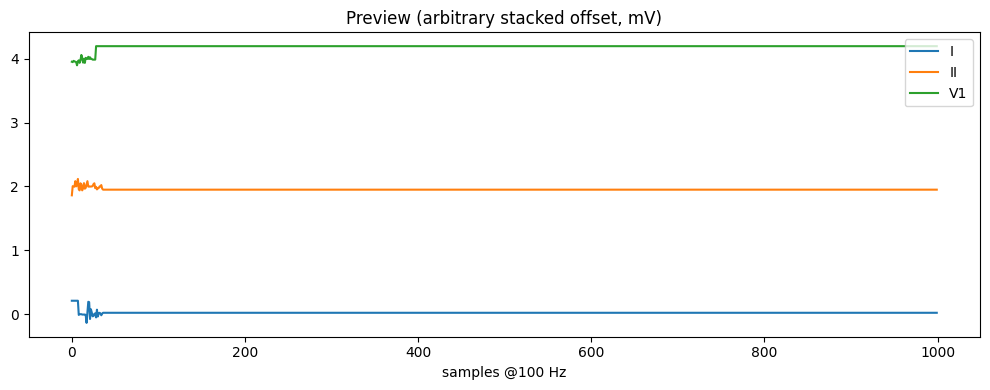


🔮 Model prediction:
  Label: Silent_MI
  Probabilities:
    Normal    :   0.00%
    Silent_MI :  99.79%
    Acute_MI  :   0.21%

✅ Done.
Submission files:
  MAT : /content/converted/download (2)_10s_100Hz.mat
  HEA : /content/converted/download (2)_10s_100Hz.hea
  DAT : /content/converted/download (2)_10s_100Hz.dat


In [62]:
# ========== ECG JPEG -> MAT + WFDB converter (+ optional model inference) ==========
# Robust version with deskew, optional px/mm override, safer resampling, and preview.
# Outputs:
#   /content/converted/<stem>_10s_100Hz.mat   -> MATLAB file with key 'val' (µV, int16) shape (12, T)
#   /content/converted/<stem>_10s_100Hz.hea/.dat  -> WFDB (fs=100 Hz, units=uV)

import os, math, io, time, numpy as np
from pathlib import Path
from google.colab import files
import cv2
from skimage.morphology import skeletonize
from scipy.signal import find_peaks
from scipy.io import savemat
import matplotlib.pyplot as plt
import wfdb
import tensorflow as tf

# ------------------ Config ------------------
OUT_DIR = Path("/content/converted")
OUT_DIR.mkdir(exist_ok=True, parents=True)

# Paper assumptions (can tweak)
ASSUME_MM_PER_MV  = 10.0   # 10 mm = 1 mV
ASSUME_MM_PER_SEC = 25.0   # 25 mm/sec
TARGET_FS         = 100    # Hz
TARGET_SECONDS    = 10.0
TARGET_LEN        = int(TARGET_FS * TARGET_SECONDS)

# Layout (4x3 typical 12-lead page)
GRID_ROWS, GRID_COLS = 4, 3
LEAD_NAMES = ["I","II","III","aVR","aVL","aVF","V1","V2","V3","V4","V5","V6"]

# Optional manual overrides (set to None to auto-detect)
FORCE_PX_PER_MM = None     # e.g., 10.0 if you know your scan scale
REVERSE_POLARITY = False   # True if your deflections look inverted after preview

# ------------------ Helpers ------------------
def read_image_rgb(path):
    img = cv2.imread(str(path))
    if img is None:
        raise ValueError(f"Cannot read image: {path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def deskew_image(img_rgb):
    """Estimate a small skew angle from grid lines and deskew image."""
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(cv2.GaussianBlur(gray, (3,3), 0), 50, 120)
    lines = cv2.HoughLines(edges, 1, np.pi/180, threshold=180)
    if lines is None:
        return img_rgb
    # Get angles near 0º or 90º (grid)
    angles = []
    for rho, theta in lines[:,0,:]:
        deg = theta * 180.0 / np.pi
        # Normalize angle to [-90, 90]
        if deg > 90: deg -= 180
        # Keep near 0 or ±90
        if abs(deg) < 15 or abs(abs(deg)-90) < 15:
            angles.append(deg)
    if not angles:
        return img_rgb
    angle = float(np.median(angles))
    if abs(angle) < 0.5:
        return img_rgb
    # Rotate
    h, w = img_rgb.shape[:2]
    M = cv2.getRotationMatrix2D((w//2, h//2), angle, 1.0)
    rotated = cv2.warpAffine(img_rgb, M, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)
    return rotated

def estimate_pixels_per_mm(img_rgb):
    """Estimate grid spacing via projection peaks; fallback to 10 px/mm."""
    if FORCE_PX_PER_MM:
        return float(FORCE_PX_PER_MM)
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    edges = cv2.Canny(blur, 30, 80)
    vproj = edges.sum(axis=0)
    hproj = edges.sum(axis=1)

    def _period(sig):
        pk, _ = find_peaks(sig, distance=8, prominence=np.percentile(sig, 80))
        if len(pk) < 5:
            return None
        diffs = np.diff(pk)
        return float(np.median(diffs)) if len(diffs) else None

    pv = _period(vproj)
    ph = _period(hproj)
    cands = [p for p in [pv, ph] if p and 3 <= p <= 30]
    if not cands:
        return 10.0
    period = float(np.median(cands))
    px_per_mm = period/5.0 if period >= 14 else period  # if likely 5mm heavy lines
    return float(np.clip(px_per_mm, 4.0, 16.0))

def split_into_leads(img_rgb):
    """Split 4x3 equal tiles with margin crop."""
    H, W = img_rgb.shape[:2]
    tiles = []
    row_h = H // GRID_ROWS
    col_w = W // GRID_COLS
    for r in range(GRID_ROWS):
        for c in range(GRID_COLS):
            y0 = r*row_h; y1 = (r+1)*row_h if r<GRID_ROWS-1 else H
            x0 = c*col_w; x1 = (c+1)*col_w if c<GRID_COLS-1 else W
            my = int(0.08*(y1-y0)); mx = int(0.06*(x1-x0))
            y0i, y1i = y0+my, y1-my
            x0i, x1i = x0+mx, x1-mx
            tile = img_rgb[max(0,y0i):min(H,y1i), max(0,x0i):min(W,x1i)]
            tiles.append(tile)
    return tiles

def trace_signal_from_tile(tile_rgb):
    """Return (T,) trace in pixel rows (top=0)."""
    gray = cv2.cvtColor(tile_rgb, cv2.COLOR_RGB2GRAY)
    norm = cv2.normalize(gray, None, 0, 255, cv2.NORM_MINMAX)
    # Adaptive kernel based on tile size
    th = max(5, int(min(tile_rgb.shape[:2]) * 0.03) | 1)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (th, th))
    bg = cv2.morphologyEx(norm, cv2.MORPH_OPEN, kernel)
    fg = cv2.subtract(norm, bg)
    # Threshold + skeleton
    _, bw = cv2.threshold(fg, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    bw = 255 - bw
    bw = (bw > 0).astype(np.uint8)
    skel = skeletonize(bw > 0)

    H, W = skel.shape
    y_trace = np.full(W, np.nan, dtype=np.float32)
    for x in range(W):
        ys = np.where(skel[:, x])[0]
        if ys.size:
            y_trace[x] = np.median(ys)
        else:
            col = gray[:, x]
            y_trace[x] = float(np.argmin(col))
    # Interp missing
    isnan = np.isnan(y_trace)
    if np.any(isnan):
        idx = np.where(~isnan)[0]
        if idx.size == 0:
            raise ValueError("No trace found in tile.")
        y_trace = np.interp(np.arange(W), idx, y_trace[idx]).astype(np.float32)
    return y_trace

def pixels_to_mv(y_pix, px_per_mm):
    """Map pixel rows to mV relative to median baseline. Upward positive."""
    baseline = float(np.median(y_pix))
    delta_pix = baseline - y_pix
    delta_mm  = delta_pix / float(px_per_mm)
    mv = delta_mm / ASSUME_MM_PER_MV
    if REVERSE_POLARITY:
        mv = -mv
    return mv.astype(np.float32)

def build_time_axis(n_cols, px_per_mm):
    mm_per_col = 1.0 / float(px_per_mm)
    sec_per_col = mm_per_col / ASSUME_MM_PER_SEC
    return np.arange(n_cols, dtype=np.float32) * sec_per_col

def resample_to_target(x_mv, t_sec, fs_target=TARGET_FS, T=TARGET_SECONDS):
    t_uniform = np.linspace(0.0, T, int(fs_target*T), endpoint=False)
    # clip t to [0, t_max] and hold edges
    t_max = max(t_sec[-1], 1e-6)
    t_clip = np.clip(t_uniform, 0.0, t_max)
    # simple linear interp on clipped domain, with edge values held
    x_interp = np.interp(t_clip, t_sec, x_mv, left=x_mv[0], right=x_mv[-1])
    return x_interp.astype(np.float32)

def convert_image_to_signals(img_path, out_stem="custom_record"):
    # 0) Load + deskew
    img0 = read_image_rgb(img_path)
    img  = deskew_image(img0)

    # 1) scale + split
    px_per_mm = estimate_pixels_per_mm(img)
    tiles = split_into_leads(img)
    if len(tiles) != 12:
        raise ValueError(f"Expected 12 tiles, got {len(tiles)}")

    # 2) trace each lead
    signals_mv = []
    for tile in tiles:
        y_pix = trace_signal_from_tile(tile)
        mv    = pixels_to_mv(y_pix, px_per_mm)
        tsec  = build_time_axis(len(mv), px_per_mm)
        mv_rs = resample_to_target(mv, tsec, fs_target=TARGET_FS, T=TARGET_SECONDS)
        signals_mv.append(mv_rs)

    # 3) stack + save
    sig_mv = np.stack(signals_mv, axis=0)         # (12, T) in mV
    sig_uV = (sig_mv * 1000.0).astype(np.float32) # µV (float)
    sig_uV_i16 = np.clip(sig_uV, -32768, 32767).astype(np.int16)

    # MAT: PTB-XL style (key 'val' in µV int16, shape (12, T))
    mat_path = OUT_DIR / f"{out_stem}.mat"
    savemat(str(mat_path), {"val": sig_uV_i16})
    print(f"✔ Saved MAT: {mat_path}")

    # WFDB: sanitize + write with wide format
    sig_uV_sanitized = np.nan_to_num(sig_uV, nan=0.0, posinf=0.0, neginf=0.0)
    sig_uV_sanitized = np.clip(sig_uV_sanitized, -1_000_000.0, 1_000_000.0)

    wfdb.wrsamp(
        record_name=str(out_stem),
        fs=TARGET_FS,
        units=["uV"] * 12,
        sig_name=LEAD_NAMES,
        p_signal=sig_uV_sanitized.T.astype(np.float64),  # (T, 12)
        fmt=["32"] * 12,
        adc_gain=[1.0] * 12,
        baseline=[0] * 12,
        write_dir=str(OUT_DIR),
    )
    hea_path = OUT_DIR / f"{out_stem}.hea"
    dat_path = OUT_DIR / f"{out_stem}.dat"
    print(f"✔ Saved WFDB: {hea_path}, {dat_path}")

    # Quick preview (first 3 leads)
    plt.figure(figsize=(10,4))
    for i, lead in enumerate([0,1,6]):  # I, II, V1
        plt.plot(sig_mv[i] + i*2.0, label=LEAD_NAMES[[0,1,6][i]])
    plt.title("Preview (arbitrary stacked offset, mV)")
    plt.xlabel("samples @100 Hz"); plt.legend(); plt.tight_layout()
    plt.show()

    return sig_mv, str(mat_path), str(hea_path)

def predict_with_trained_model(sig_mv, age_years=56, sex_str="male", model_path="/content/silent_mi_cnn_wfdb.h5"):
    """Run trained ECG+demo model (12 x 1000 mV) if present."""
    if not Path(model_path).exists():
        print("⚠ Model not found; skipping inference.")
        return None, None

    # match training preprocessing: per-lead z-normalization
    sig = sig_mv.copy()
    mu = np.median(sig, axis=1, keepdims=True)
    sd = np.std(sig, axis=1, keepdims=True) + 1e-6
    sig = (sig - mu) / sd

    x_ecg  = sig[np.newaxis, ..., None].astype(np.float32)
    def sex_to_num(s):
        s = str(s).strip().lower()
        if s.startswith("m"): return 1
        if s.startswith("f"): return 0
        try: return 1 if float(s)>0.5 else 0
        except: return 0
    x_demo = np.array([[float(age_years), sex_to_num(sex_str)]], np.float32)

    model = tf.keras.models.load_model(model_path)
    probs = model.predict({"ecg": x_ecg, "demo": x_demo}, verbose=0)[0]
    classes = ["Normal","Silent_MI","Acute_MI"]
    pred = classes[int(np.argmax(probs))]
    return pred, {classes[i]: float(probs[i]) for i in range(3)}

# ------------------ Upload & run ------------------
print("📤 Upload your ECG image (jpg/png):")
uploaded = files.upload()
if not uploaded:
    raise SystemExit("No file uploaded.")

img_name = list(uploaded.keys())[0]
img_path = Path("/content") / img_name
stem = img_path.stem

# Convert
out_stem = f"{stem}_10s_100Hz"
sig_mv, mat_path, hea_path = convert_image_to_signals(img_path, out_stem=out_stem)

# Optional: predict with your trained model (if present)
AGE = 56
SEX = "male"
pred, probs = predict_with_trained_model(sig_mv, AGE, SEX, model_path="/content/silent_mi_cnn_wfdb.h5")
if pred is not None:
    print("\n🔮 Model prediction:")
    print("  Label:", pred)
    print("  Probabilities:")
    for k, v in probs.items():
        print(f"    {k:10s}: {v*100:6.2f}%")

print("\n✅ Done.")
print("Submission files:")
print("  MAT :", mat_path)
print("  HEA :", hea_path)
print("  DAT :", str(Path(hea_path).with_suffix(".dat")))


📤 Upload your ECG image (jpg/png):


Saving normal ecgg.jpg to normal ecgg.jpg
px/mm: 10.00 | paper speed: 25.0 mm/s | polarity flipped: False
Estimated duration before resample (median across leads): 0.71 s
Per-lead mV ranges (min,max): [(-0.31732648611068726, 0.15642258524894714), (-0.21128207445144653, 0.18019719421863556), (-0.2956884503364563, 0.1881283074617386), (-0.3128899931907654, 0.23576007783412933), (-0.3382832407951355, 0.2471872717142105), (-0.22058941423892975, 0.2040928602218628), (-0.3340633809566498, 0.18088732659816742), (-0.16215096414089203, 0.3164007365703583), (-0.1899704784154892, 0.22559449076652527), (-0.3340633809566498, 0.18088732659816742), (-0.7019014358520508, 0.19787341356277466), (-0.3340633809566498, 0.18088732659816742)]
Output shape (leads x samples): (12, 1000) (expected (12, 1000))
✔ Saved MAT: /content/converted/normal ecgg_10s_100Hz.mat
✔ Saved WFDB: /content/converted/normal ecgg_10s_100Hz.hea, /content/converted/normal ecgg_10s_100Hz.dat


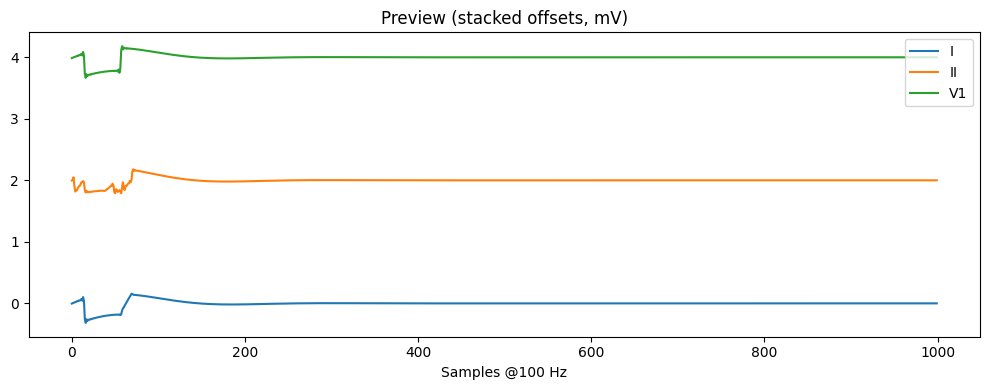


🔮 Model prediction:
  Label: Silent_MI
  Probabilities:
    Normal    :   0.00%
    Silent_MI :  99.66%
    Acute_MI  :   0.34%

✅ Done.
Submission files:
  MAT : /content/converted/normal ecgg_10s_100Hz.mat
  HEA : /content/converted/normal ecgg_10s_100Hz.hea
  DAT : /content/converted/normal ecgg_10s_100Hz.dat


In [71]:
# ========== ECG JPEG -> MAT + WFDB converter (+ optional model inference) ==========
# More robust: paper-speed override, lead order remap, band-pass, telemetry & preview.

import os, math, io, time, numpy as np
from pathlib import Path
from google.colab import files
import cv2
from skimage.morphology import skeletonize
from scipy.signal import find_peaks, butter, filtfilt
from scipy.io import savemat
import matplotlib.pyplot as plt
import wfdb
import tensorflow as tf

# ------------------ Config ------------------
OUT_DIR = Path("/content/converted"); OUT_DIR.mkdir(exist_ok=True, parents=True)

# Paper/layout assumptions (tweak here)
MM_PER_MV               = 10.0        # 10 mm = 1 mV
PAPER_SPEED_MM_PER_SEC  = 25.0        # try 50.0 if your strip is at 50 mm/s
TARGET_FS               = 100         # Hz
TARGET_SECONDS          = 10.0
TARGET_LEN              = int(TARGET_FS * TARGET_SECONDS)

GRID_ROWS, GRID_COLS = 4, 3
LEAD_NAMES = ["I","II","III","aVR","aVL","aVF","V1","V2","V3","V4","V5","V6"]

# Optional overrides / toggles
FORCE_PX_PER_MM   = None      # e.g., 10.0 to skip auto detection
REVERSE_POLARITY  = False     # flip sign if deflections look inverted
USE_BANDPASS      = True      # 0.5–40 Hz after resample
SHOW_PREVIEW      = True
CONFIDENCE_ABSTAIN = 0.60     # if max prob < thresh: label "Uncertain"

# If your printed page uses a different tile order, remap here:
# tiles are [row0col0,row0col1,row0col2,row1col0,...,row3col2]
INDEX_MAP = [0,1,2, 3,4,5, 6,7,8, 9,10,11]  # change if your panel order differs

# ------------------ Helpers ------------------
def read_image_rgb(path):
    img = cv2.imread(str(path))
    if img is None: raise ValueError(f"Cannot read image: {path}")
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def deskew_image(img_rgb):
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(cv2.GaussianBlur(gray, (3,3), 0), 50, 120)
    lines = cv2.HoughLines(edges, 1, np.pi/180, threshold=180)
    if lines is None: return img_rgb
    angles = []
    for rho, theta in lines[:,0,:]:
        deg = theta*180/np.pi
        if deg > 90: deg -= 180
        if abs(deg) < 15 or abs(abs(deg)-90) < 15:
            angles.append(deg)
    if not angles: return img_rgb
    angle = float(np.median(angles))
    if abs(angle) < 0.5: return img_rgb
    h,w = img_rgb.shape[:2]
    M = cv2.getRotationMatrix2D((w//2, h//2), angle, 1.0)
    return cv2.warpAffine(img_rgb, M, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)

def estimate_pixels_per_mm(img_rgb):
    if FORCE_PX_PER_MM: return float(FORCE_PX_PER_MM)
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    edges = cv2.Canny(blur, 30, 80)
    vproj = edges.sum(axis=0); hproj = edges.sum(axis=1)
    def _period(sig):
        pk,_ = find_peaks(sig, distance=8, prominence=np.percentile(sig, 80))
        if len(pk) < 5: return None
        d = np.diff(pk)
        return float(np.median(d)) if len(d) else None
    pv = _period(vproj); ph = _period(hproj)
    cands = [p for p in [pv, ph] if p and 3 <= p <= 30]
    if not cands: return 10.0
    period = float(np.median(cands))
    px_per_mm = period/5.0 if period >= 14 else period
    return float(np.clip(px_per_mm, 4.0, 16.0))

def split_into_leads(img_rgb):
    H,W = img_rgb.shape[:2]
    tiles=[]; row_h=H//GRID_ROWS; col_w=W//GRID_COLS
    for r in range(GRID_ROWS):
        for c in range(GRID_COLS):
            y0=r*row_h; y1=(r+1)*row_h if r<GRID_ROWS-1 else H
            x0=c*col_w; x1=(c+1)*col_w if c<GRID_COLS-1 else W
            my=int(0.08*(y1-y0)); mx=int(0.06*(x1-x0))
            tile = img_rgb[max(0,y0+my):min(H,y1-my), max(0,x0+mx):min(W,x1-mx)]
            tiles.append(tile)
    # remap order if needed
    tiles = [tiles[i] for i in INDEX_MAP]
    return tiles

def trace_signal_from_tile(tile_rgb):
    gray = cv2.cvtColor(tile_rgb, cv2.COLOR_RGB2GRAY)
    norm = cv2.normalize(gray, None, 0, 255, cv2.NORM_MINMAX)
    th = max(5, int(min(tile_rgb.shape[:2])*0.03) | 1)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (th, th))
    bg = cv2.morphologyEx(norm, cv2.MORPH_OPEN, kernel)
    fg = cv2.subtract(norm, bg)
    _, bw = cv2.threshold(fg, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    bw = 255 - bw
    skel = skeletonize((bw>0).astype(np.uint8) > 0)
    H,W = skel.shape
    y = np.full(W, np.nan, np.float32)
    for x in range(W):
        ys = np.where(skel[:,x])[0]
        y[x] = np.median(ys) if ys.size else float(np.argmin(gray[:,x]))
    if np.isnan(y).any():
        idx = np.where(~np.isnan(y))[0]
        if idx.size==0: raise ValueError("No trace found in tile.")
        y = np.interp(np.arange(W), idx, y[idx]).astype(np.float32)
    return y

def pixels_to_mv(y_pix, px_per_mm):
    baseline = float(np.median(y_pix))
    delta_pix = baseline - y_pix
    delta_mm  = delta_pix / float(px_per_mm)
    mv = delta_mm / MM_PER_MV
    return (-mv if REVERSE_POLARITY else mv).astype(np.float32)

def build_time_axis(n_cols, px_per_mm):
    mm_per_col = 1.0 / float(px_per_mm)
    sec_per_col = mm_per_col / PAPER_SPEED_MM_PER_SEC
    return np.arange(n_cols, dtype=np.float32) * sec_per_col

def resample_to_target(x_mv, t_sec, fs_target=TARGET_FS, T=TARGET_SECONDS):
    t_uniform = np.linspace(0.0, T, int(fs_target*T), endpoint=False)
    t_max = max(t_sec[-1], 1e-6)
    t_clip = np.clip(t_uniform, 0.0, t_max)
    x = np.interp(t_clip, t_sec, x_mv, left=x_mv[0], right=x_mv[-1]).astype(np.float32)
    if USE_BANDPASS:
        # 0.5–40 Hz band-pass, 3rd order
        lo, hi = 0.5, 40.0
        b,a = butter(3, [lo/(fs_target/2), hi/(fs_target/2)], btype='band')
        # guard against all-constant input
        if np.std(x) > 1e-6:
            x = filtfilt(b, a, x).astype(np.float32)
    return x

def convert_image_to_signals(img_path, out_stem="custom_record"):
    # Load + deskew
    img0 = read_image_rgb(img_path)
    img  = deskew_image(img0)

    # Scale + tiles
    px_per_mm = estimate_pixels_per_mm(img)
    tiles = split_into_leads(img)
    if len(tiles) != 12: raise ValueError(f"Expected 12 tiles, got {len(tiles)}")

    # Trace each lead
    signals_mv = []
    est_durations = []
    for tile in tiles:
        y_pix = trace_signal_from_tile(tile)
        mv    = pixels_to_mv(y_pix, px_per_mm)
        tsec  = build_time_axis(len(mv), px_per_mm)
        est_durations.append(float(tsec[-1] if len(tsec) else 0))
        mv_rs = resample_to_target(mv, tsec, fs_target=TARGET_FS, T=TARGET_SECONDS)
        signals_mv.append(mv_rs)

    sig_mv = np.stack(signals_mv, axis=0)          # (12, T) mV
    sig_uV = (sig_mv * 1000.0).astype(np.float32)  # µV
    sig_uV_i16 = np.clip(sig_uV, -32768, 32767).astype(np.int16)

    # Telemetry
    print(f"px/mm: {px_per_mm:.2f} | paper speed: {PAPER_SPEED_MM_PER_SEC} mm/s | polarity flipped: {REVERSE_POLARITY}")
    print("Estimated duration before resample (median across leads):", f"{np.median(est_durations):.2f} s")
    rng = [(float(sig_mv[i].min()), float(sig_mv[i].max())) for i in range(12)]
    print("Per-lead mV ranges (min,max):", rng)
    print("Output shape (leads x samples):", sig_mv.shape, "(expected (12, 1000))")

    # Save MAT (PTB-XL style: 'val' in µV int16)
    mat_path = OUT_DIR / f"{out_stem}.mat"
    savemat(str(mat_path), {"val": sig_uV_i16})
    print(f"✔ Saved MAT: {mat_path}")

    # WFDB write (sanitized)
    sig_uV_sanitized = np.nan_to_num(sig_uV, nan=0.0, posinf=0.0, neginf=0.0)
    sig_uV_sanitized = np.clip(sig_uV_sanitized, -1_000_000.0, 1_000_000.0)
    wfdb.wrsamp(
        record_name=str(out_stem),
        fs=TARGET_FS,
        units=["uV"]*12,
        sig_name=LEAD_NAMES,
        p_signal=sig_uV_sanitized.T.astype(np.float64),
        fmt=["32"]*12,
        adc_gain=[1.0]*12,
        baseline=[0]*12,
        write_dir=str(OUT_DIR),
    )
    hea_path = OUT_DIR / f"{out_stem}.hea"
    dat_path = OUT_DIR / f"{out_stem}.dat"
    print(f"✔ Saved WFDB: {hea_path}, {dat_path}")

    if SHOW_PREVIEW:
        plt.figure(figsize=(10,4))
        for i, lead_idx in enumerate([0,1,6]):  # I, II, V1
            plt.plot(sig_mv[lead_idx] + i*2.0, label=LEAD_NAMES[lead_idx])
        plt.title("Preview (stacked offsets, mV)"); plt.xlabel("Samples @100 Hz")
        plt.legend(); plt.tight_layout(); plt.show()

    return sig_mv, str(mat_path), str(hea_path)

def predict_with_trained_model(sig_mv, age_years=56, sex_str="male", model_path="/content/silent_mi_cnn_wfdb.h5"):
    if not Path(model_path).exists():
        print("⚠ Model not found; skipping inference."); return None, None
    # per-lead z-norm (matches training)
    sig = sig_mv.copy()
    mu = np.median(sig, axis=1, keepdims=True)
    sd = np.std(sig, axis=1, keepdims=True) + 1e-6
    sig = (sig - mu) / sd
    x_ecg = sig[np.newaxis, ..., None].astype(np.float32)

    def sex_to_num(s):
        s = str(s).strip().lower()
        if s.startswith("m"): return 1
        if s.startswith("f"): return 0
        try: return 1 if float(s)>0.5 else 0
        except: return 0
    x_demo = np.array([[float(age_years), sex_to_num(sex_str)]], np.float32)

    model = tf.keras.models.load_model(model_path)
    probs = model.predict({"ecg": x_ecg, "demo": x_demo}, verbose=0)[0]
    classes = ["Normal","Silent_MI","Acute_MI"]
    pred_idx = int(np.argmax(probs)); pred = classes[pred_idx]
    if CONFIDENCE_ABSTAIN and float(probs[pred_idx]) < CONFIDENCE_ABSTAIN:
        pred = "Uncertain"
    return pred, {classes[i]: float(probs[i]) for i in range(3)}

# ------------------ Upload & run ------------------
print("📤 Upload your ECG image (jpg/png):")
uploaded = files.upload()
if not uploaded: raise SystemExit("No file uploaded.")
img_name = list(uploaded.keys())[0]
img_path = Path("/content") / img_name
out_stem = f"{img_path.stem}_10s_100Hz"

sig_mv, mat_path, hea_path = convert_image_to_signals(img_path, out_stem=out_stem)

# Optional: predict with your trained model (if present)
AGE = 30; SEX = "male"
pred, probs = predict_with_trained_model(sig_mv, AGE, SEX, model_path="/content/silent_mi_cnn_wfdb.h5")
if pred is not None:
    print("\n🔮 Model prediction:")
    print("  Label:", pred)
    print("  Probabilities:")
    for k, v in probs.items(): print(f"    {k:10s}: {v*100:6.2f}%")

print("\n✅ Done.")
print("Submission files:")
print("  MAT :", mat_path)
print("  HEA :", hea_path)
print("  DAT :", str(Path(hea_path).with_suffix('.dat')))
